# 实验5 人名-国籍识别

**10185501402 孙秋实 2018级**

## 实验描述

在开始本次实验前，我首先把`train_name_list.txt`和`train_name_label.txt`合并到一个csv文件中方便读取，一共有19种标签（18个国家名+火星人），共14482条数据。

然后对数据集进行划分（认为数据已经被随机打乱了）：
1. 训练集12,000条
2. 验证集2,482条

**Remark:**根据助教老师的提示，若用人名包含的字符串字串匹配进行暴力预测，该暴力算法在训练数据集上可以达到 $93\%$ 的准确率，在测试集上可以达到 $76\%$ 的准确率（好高），所以将 $76\%$ 的预测准确率设定为baseline

## 简介

在本次实验中，我使用GRU来完成这个任务，至于为什么选GRU，是因为：

*We choose to use Gated Recurrent Unit (GRU) (Cho et al., 2014) in our experiment since it performs similarly to LSTM (Hochreiter \& Schmidhuber, 1997) but is computationally cheaper.*

首先就是因为它跑的比较快一点，而且速度上比LSTM快很多

然后，GRU的设计是为了解决标准RNN的梯度弥散，GRU使用了更新门（update gate）与重置门（reset gate）。这两个门控向量决定了哪些信息最终能作为门控循环单元的输出。这两个门控机制的特殊之处在于其能够保存长期序列中的信息，且不会随时间而清除或因为与预测不相关而移除信息。

参考：https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

<img src="GRU-struct.png" width = "40%" />
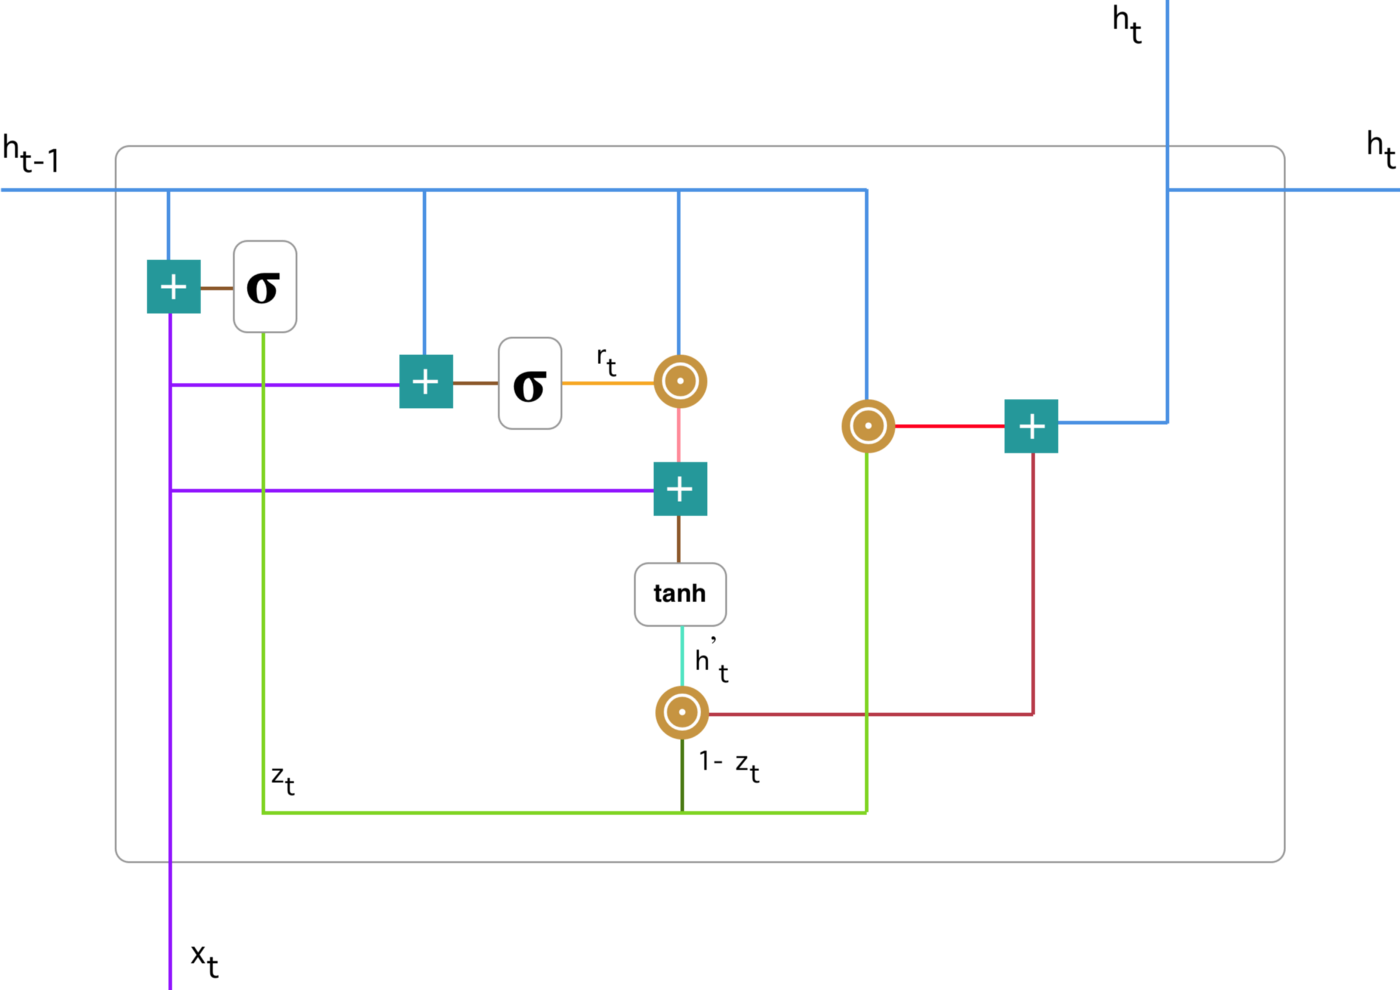

数学形式的表达如下：

$$\begin{array}{l}
r_{t}=\sigma\left(W_{i r} x_{t}+b_{i r}+W_{h r} h_{(t-1)}+b_{h r}\right) \\
z_{t}=\sigma\left(W_{i z} x_{t}+b_{i z}+W_{h z} h_{(t-1)}+b_{h z}\right) \\
n_{t}=\tanh \left(W_{i n} x_{t}+b_{i n}+r_{t} *\left(W_{h n} h(t-1)+b_{h n}\right)\right) \\
h_{t}=\left(1-z_{t}\right) * n_{t}+z_{t} * h_{(t-1)}
\end{array}$$

载入框架，把RNN相应的模块加载进来，因为序列长度需要统一所以这里需要padding

**最后使用双向GRU，在12,000条数据上训练64个epoch，可以达到83%+的验证集准确率**

## 模型实现

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence 

加载一些Basic的模块

In [2]:
import csv
import time
import math
import numpy as np
import matplotlib.pyplot as plt

加载这个init模块是为了测试一下不同的初始化方式对GRU训练效果的影响，比如正交初始化/均匀分布初始化

In [3]:
import torch.nn.init as init

In [4]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-32GB'

In [5]:
USE_GPU=True

dtype=torch.float32

if USE_GPU and torch.cuda.is_available():
    device=torch.device("cuda:0")
    #再蹭了一下实验室的GPU
else:
    device=torch.device('cpu')
print('Using Device:', device)

Using Device: cuda:0


**此处初始化参数，注意字典大小**

In [6]:
hidden_layer_size = 256 # hidden layers size
batchsize = 256  # batch size
rnn_layers = 4 # RNN的层数
Training_Epoch = 35 # epochs
Country_num = 19 # 国家个数（18个国家+火星）
dict_size = 65535 
# 构造字典

实验开始前先准备数据，读取数据，取出人名和国家名，然后为国家名建立字典，用数字标记国家

In [7]:
class make_data(Dataset):  
    # 实验开始前先准备数据，读取数据，取出人名和国家名，然后为国家名建立字典，用数字标记国家
    def __init__(self, set_type='train'):
        if(set_type == 'train'):
            filename = "name-country-train.csv"
        elif(set_type == 'validation'):
            filename = "name-country-valid.csv"
        else:
            filename = "name-country-test.csv"
        # 这里分三个数据集分别读进来
        with open(filename, "rt") as f:  
            reader = csv.reader(f)
            rows = list(reader)
        self.names = [row[0] for row in rows] # 获得名字
        self.len = len(self.names)
        self.countries = [row[1] for row in rows] # 获得对应的标签
        self.country_list = list(sorted(set(self.countries)))  # 去重排序
        self.country_dict = self.getCountryDict()  # 国家名词典

    def __getitem__(self, index):
        return self.names[index], self.country_dict[self.countries[index]] # 前者是名字字符串，后者是国家的索引
    
    def __len__(self):
        return self.len
    
    def getCountryDict(self): #给国家-数字的组合建立一个字典，用数字来标记是哪个国家
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict
    
    def idx2country(self, index): 
        # 这个就是为了得到分类之后，返回下标对应的字符串，也就是显示使用的
        return self.country_list[index]

In [8]:
def make_tensors(names, countries): 
    # 名字->张量形式表示
    sequences_and_lengths = [name2list(i)for i in names]
    name_sequences = [sl[0] for sl in sequences_and_lengths] 
    seq_lengths = torch.LongTensor([sl[1]for sl in sequences_and_lengths]) 
    countries = countries.long() 
    # 数字 -> longtensor
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long() 
    #先全设置为0，然后填充,长度是BatchSize
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]
    return seq_tensor, seq_lengths, countries

In [9]:
def name2list(name): 
    # 将名字字符串的字母转换成ASCII
    # 注意如波兰人名，德国人名里面会有非26字母的符号
    name_arr = [ord(c) for c in name] 
    return name_arr, len(name_arr)

In [10]:
trainset = make_data(set_type = 'train') # train数据
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
print(trainset.getCountryDict())

validset = make_data(set_type = 'validation') # validation数据
validloader = DataLoader(validset, batch_size=batchsize, shuffle=False)

print("Number Of Countries: ",Country_num)

{'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Mars': 12, 'Polish': 13, 'Portuguese': 14, 'Russian': 15, 'Scottish': 16, 'Spanish': 17, 'Vietnamese': 18}
Number Of Countries:  19


**卧槽...为什么有火星人**

然后实现一个GRU类

In [11]:
class GRU_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True, orth=True):
        super(GRU_Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1 

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,  
                          # 输入维度、输出维度、层数
                          # 再用bidirectional这个flag用来说明是单向还是双向
                         dropout=0.5,
                         bidirectional=bidirectional)
        
        if(orth):
            print('using orthogonal initialization')
            nn.init.orthogonal_(self.gru.weight_ih_l0)
            nn.init.orthogonal_(self.gru.weight_hh_l0)
        else:
            print('using zero initialization')
            
        self.fc = nn.Linear(hidden_size * self.n_directions, output_size)
        
    def __init__hidden(self, batch_size):  
        # 创建全0隐层
        hidden = torch.zeros(self.n_layers * self.n_directions,
                            batch_size, self.hidden_size)
        return hidden 
    
    def forward(self, input, seq_lengths):
        # input shape:B * S -> S * B
        input = input.t()
        batch_size = input.size(1)
        
        hidden = self.__init__hidden(batch_size) # 隐藏层h0
        embedding = self.embedding(input)
        
        # pack them up
        gru_input = pack_padded_sequence(embedding, seq_lengths)  # 填充了可能有很多的0，所以为了提速，将每个序列以及序列的长度给出
        
        output, hidden = self.gru(gru_input, hidden) # 只需要hidden
        if self.n_directions == 2: #实现双向的GRU，需要拼接起来
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1] # 如果是单向的，则不用处理
        fc_output = self.fc(hidden_cat) # 最后来个全连接层,确保层想要的维度（类别数）
        return fc_output

In [12]:
training_loss_zero_init = []
training_loss_orth_init = []
# 上面两个列表是用来测试初始化的时候正交初始化的影响的

training_loss_best = []
def train_model(classifier):
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1): # 记载的下标从1开始
        inputs, seq_lengths, target = make_tensors(names, countries)
        output = classifier(inputs, seq_lengths) # 预测输出
        loss = criterion(output, target) 
        # 求交叉熵损失
        optimizer.zero_grad() # 梯度清零
        loss.backward()
        training_loss_best.append(loss)
        # 反向传播
        optimizer.step() # update params
        total_loss += loss.item() #还是要注意这是个tenor
        loss_temp = total_loss/(i*len(inputs))
        if i % 20 ==0:
            print(f'[{time_count(start)}] Epoch {epoch}', end='')
            print(f' loss={total_loss / (i * len(inputs))}')
    return total_loss

In [13]:
def validate_model(classifier):
    correct = 0
    total = len(validset)
    print("Test on validaiton set:")
    with torch.no_grad():
        for i, (names, countries) in enumerate(validloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries) 
            # 将名字的字符串转换成tensors表示
            output = classifier(inputs, seq_lengths) 
            # 预测输出
            pred = output.max(dim=1, keepdim=True)[1] 
            # 预测出来是个向量，里面的值相当于概率，取最大的
#             print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item() # 预测和实际标签相同则正确率加1
        percent = '%.3f' % (100 * correct / total)
        print(f'Validation set accuracy: {correct} / {total} {percent}%')
    return correct / total

In [14]:
def time_count(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)
# 学会了怎么给一个epoch计时

In [15]:
# torch.save(classifier,"gru_classifier.bin")

## Best Model (模型选择过程请看Appendix)

### 训练过程

In [47]:
Training_Epoch = 64 # epochs
gru_classifier = GRU_Classifier(dict_size,hidden_layer_size,Country_num,rnn_layers) # 初始化一个GRU分类器
criterion = torch.nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(gru_classifier.parameters(), 
                             lr=3e-4) 
start = time.time()
print("Training for %d epochs..." % Training_Epoch)
acc_list = []

for epoch in range(1, Training_Epoch + 1):
    train_model(gru_classifier)
    valid_acc = validate_model(gru_classifier)
    acc_list.append(valid_acc) # 存入列表，后面画图使用

using orthogonal initialization
Training for 64 epochs...
 11s] Epoch 1 loss=0.007871632021851838
 loss= 0.007871632021851838
 23s] Epoch 1 loss=0.006772850069683045
 loss= 0.006772850069683045
Test on validaiton set:
Validation set accuracy: 1595 / 2482 64.263%
 41s] Epoch 2 loss=0.004961913474835456
 loss= 0.004961913474835456
 53s] Epoch 2 loss=0.004603174445219338
 loss= 0.004603174445219338
Test on validaiton set:
Validation set accuracy: 1750 / 2482 70.508%
 11s] Epoch 3 loss=0.003735010779928416
 loss= 0.003735010779928416
 23s] Epoch 3 loss=0.0036675209645181893
 loss= 0.0036675209645181893
Test on validaiton set:
Validation set accuracy: 1853 / 2482 74.658%
 41s] Epoch 4 loss=0.003181580756790936
 loss= 0.003181580756790936
 53s] Epoch 4 loss=0.003203729935921729
 loss= 0.003203729935921729
Test on validaiton set:
Validation set accuracy: 1936 / 2482 78.002%
 11s] Epoch 5 loss=0.0028563971747644244
 loss= 0.0028563971747644244
 22s] Epoch 5 loss=0.0028248404210899024
 loss= 0.

In [58]:
torch.save(gru_classifier,'gru_classifier_v3')

### 可视化训练结果

先绘制验证集每个epoch的训练精度曲线

In [56]:
def visualize_accuracy(data1):
    line1,=plt.plot(data1,'slateblue',label='Validation Accuracy',marker='1')
    plt.title('Visualize Validation Accuracy')
    plt.legend(handles=[line1],labels=['Validation Accuracy'], loc='best')
    plt.grid(linestyle='-.')
    plt.gcf().set_size_inches(8,5)
    plt.xlabel('Iteration')
    plt.ylabel('Validation Accuracy')
    plt.show()

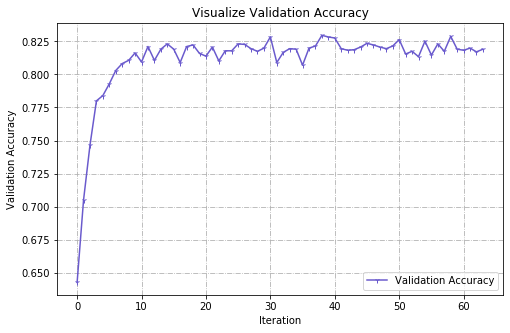

In [57]:
visualize_accuracy(acc_list)

然后为损失绘图

In [52]:
def visualize_loss_curve(data1):
    line1,=plt.plot(data1,'c',label='relu_training_loss')
    plt.title('Visualize Training Loss')
    plt.legend(handles=[line1],labels=['GRU Training loss'], loc='best')
    plt.grid(linestyle='-.')
    plt.gcf().set_size_inches(12, 7)
    plt.xlabel('Iteration')
    plt.ylabel('Training_loss')
    plt.show()

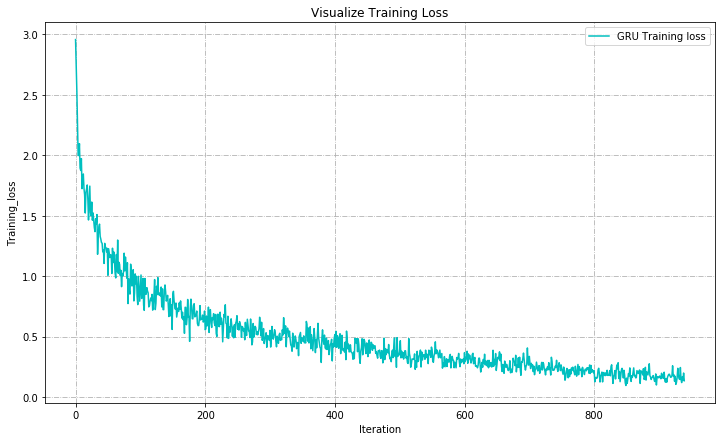

In [18]:
visualize_loss_curve(training_loss)

**可以看到，验证集的准确率最高达到83%**

## 调试循环神经网络

对于循环神经网络而言，双向循环神经网络分别在时间维以顺序和逆序（前向/后向）依次处理输入序列，并将每个时间步RNN的输出拼接成为最终的输出层。这样每个时间步的输出节点，都包含了输入序列中当前时刻完整的过去和未来的上下文信息。

在这个任务上，我们对比一下二者的性能差异

### 对比双向GRU与单向GRU

In [16]:
training_loss_uni = []
training_loss_bi = []

def train_uni_bi_model(classifier,training_loss):
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1): # 记载的下标从1开始
        inputs, seq_lengths, target = make_tensors(names, countries)
        output = classifier(inputs, seq_lengths) # 预测输出
        loss = criterion(output, target) 
        # 求交叉熵损失
        optimizer.zero_grad() # 梯度清零
        loss.backward()
        training_loss.append(loss)
        # 反向传播
        optimizer.step() # update params
        total_loss += loss.item() #还是要注意这是个tenor
        loss_temp = total_loss/(i*len(inputs))
        if i % 20 ==0:
            print(f'[{time_count(start)}] Epoch {epoch}', end='')
            print(f' loss={total_loss / (i * len(inputs))}')
    return total_loss

在这个对比任务上，我们只训练10个epoch，看看二者的差异

In [17]:
Training_Epoch = 10 # epochs
gru_unidirectional = GRU_Classifier(dict_size,hidden_layer_size,Country_num,rnn_layers,bidirectional=False) # 初始化一个GRU分类器
criterion = torch.nn.CrossEntropyLoss() # 依然使用交叉熵损失函数
optimizer = torch.optim.Adam(gru_unidirectional.parameters(), 
                             lr=3e-4) 
start = time.time()
print("Training for %d epochs..." % Training_Epoch)
acc_list_uni = []
for epoch in range(1, Training_Epoch + 1):
    train_uni_bi_model(gru_unidirectional,training_loss_uni)
    valid_acc = validate_model(gru_unidirectional)
    acc_list_uni.append(valid_acc) # 存入列表，后面画图使用

using orthogonal initialization
Training for 10 epochs...
 7s] Epoch 1 loss=0.0090660332236439
 14s] Epoch 1 loss=0.008098031266126782
Test on validaiton set:
Validation set accuracy: 1266 / 2482 51.007%
 25s] Epoch 2 loss=0.0062644691206514835
 31s] Epoch 2 loss=0.006003658194094897
Test on validaiton set:
Validation set accuracy: 1623 / 2482 65.391%
 42s] Epoch 3 loss=0.005029450170695782
 48s] Epoch 3 loss=0.004893575387541205
Test on validaiton set:
Validation set accuracy: 1699 / 2482 68.453%
 59s] Epoch 4 loss=0.004408894432708621
 6s] Epoch 4 loss=0.004319202323677019
Test on validaiton set:
Validation set accuracy: 1783 / 2482 71.837%
 16s] Epoch 5 loss=0.003883123630657792
 23s] Epoch 5 loss=0.003844790707807988
Test on validaiton set:
Validation set accuracy: 1849 / 2482 74.496%
 34s] Epoch 6 loss=0.0035186265129595997
 40s] Epoch 6 loss=0.0035118659608997403
Test on validaiton set:
Validation set accuracy: 1853 / 2482 74.658%
 51s] Epoch 7 loss=0.0031788547174073757
 57s] Ep

In [18]:
Training_Epoch = 10 # epochs
gru_bidirectional = GRU_Classifier(dict_size,hidden_layer_size,Country_num,rnn_layers,bidirectional=True) # 初始化一个GRU分类器
criterion = torch.nn.CrossEntropyLoss() # 依然使用交叉熵损失函数
optimizer = torch.optim.Adam(gru_bidirectional.parameters(), 
                             lr=3e-4) 
start = time.time()
print("Training for %d epochs..." % Training_Epoch)
acc_list_bi = []
for epoch in range(1, Training_Epoch + 1):
    train_uni_bi_model(gru_bidirectional,training_loss_bi)
    valid_acc = validate_model(gru_bidirectional)
    acc_list_bi.append(valid_acc) # 存入列表，后面画图使用

using orthogonal initialization
Training for 10 epochs...
 12s] Epoch 1 loss=0.00780683639459312
 24s] Epoch 1 loss=0.006807005079463124
Test on validaiton set:
Validation set accuracy: 1597 / 2482 64.343%
 43s] Epoch 2 loss=0.00493627623654902
 55s] Epoch 2 loss=0.004581017605960369
Test on validaiton set:
Validation set accuracy: 1761 / 2482 70.951%
 14s] Epoch 3 loss=0.0038548206677660344
 26s] Epoch 3 loss=0.0037565842911135407
Test on validaiton set:
Validation set accuracy: 1858 / 2482 74.859%
 45s] Epoch 4 loss=0.003277836530469358
 57s] Epoch 4 loss=0.0032334472227375953
Test on validaiton set:
Validation set accuracy: 1909 / 2482 76.914%
 17s] Epoch 5 loss=0.0028741036774590613
 29s] Epoch 5 loss=0.0028809272451326253
Test on validaiton set:
Validation set accuracy: 1945 / 2482 78.364%
 48s] Epoch 6 loss=0.0027027778909541667
 0s] Epoch 6 loss=0.002626398706343025
Test on validaiton set:
Validation set accuracy: 1976 / 2482 79.613%
 19s] Epoch 7 loss=0.0025001207948662342
 32s

**我们可以明确的感受到，双向GRU的训练时间比单向GRU快很多，单向GRU在10个epoch的时间开销是不到3min，而双向GRU在10个epoch上的时间开销超过了5min，但精确度稍高一些**

### 可视化对比

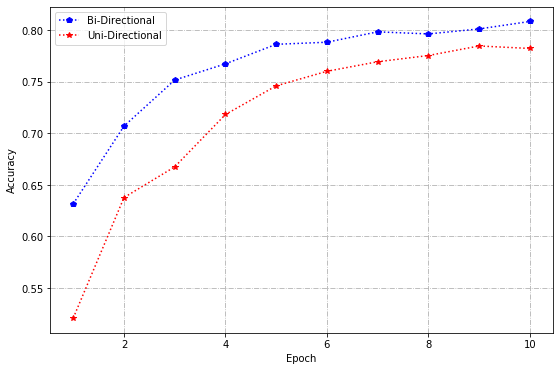

In [72]:
# 画图
epoch = np.arange(1, len(acc_list_bi) + 1, 1) # 步长为1
acc_list = np.array(acc_list)
line1,=plt.plot(epoch, acc_list_bi,'p:b')
line2,=plt.plot(epoch, acc_list_uni,'*:r')
plt.legend(handles=[line1,line2],labels=['Bi-Directional','Uni-Directional'], loc='best')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.gcf().set_size_inches(9, 6)
plt.grid(linestyle='-.')
plt.show()

可以看到，双向GRU的效果好于单向GRU，但随着训练轮次的不断增加，二者性能会越发接近

In [26]:
def visualize_loss_curve2(data1,data2):
    line1,=plt.plot(data1,'royalblue',label='uni-directional-loss')
    line2,=plt.plot(data2,'orangered',label='bi-directional-loss')
    plt.title('Visualize Training Loss')
    plt.legend(handles=[line1,line2],labels=['uni-directional-loss','bi-directional-loss'], loc='best')
    plt.grid(linestyle='-.')
    plt.gcf().set_size_inches(12, 7)
    plt.xlabel('Iteration')
    plt.ylabel('Training_loss')
    plt.show()

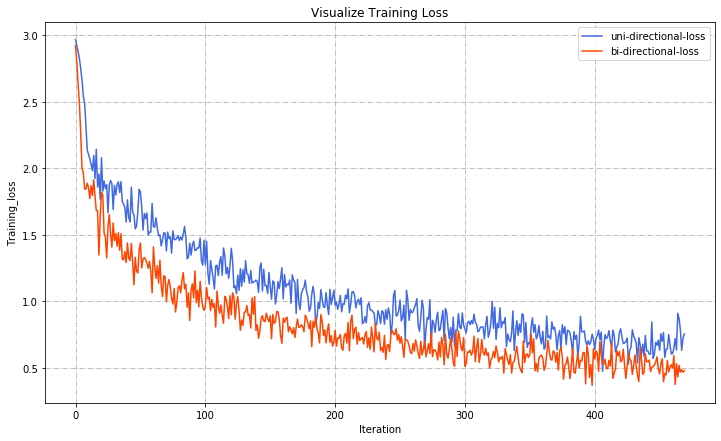

In [27]:
visualize_loss_curve2(training_loss_uni,training_loss_bi)

### 比较GRU不同的初始化方法对最终性能的影响

不论是GRU还是LSTM都涉及频繁的对同个矩阵的乘法，因此，模型参数的初始化也许会对最终性能有一定的影响，我们通过

`nn.init.orthogonal_(self.gru.weight_ih_l0)`

`nn.init.orthogonal_(self.gru.weight_hh_l0)`

来对权重矩阵进行正交初始化，并且比较其与全零初始化的差异

（因为训练过程比较长，所以把输出去掉了，只用损失值进行了可视化）
           

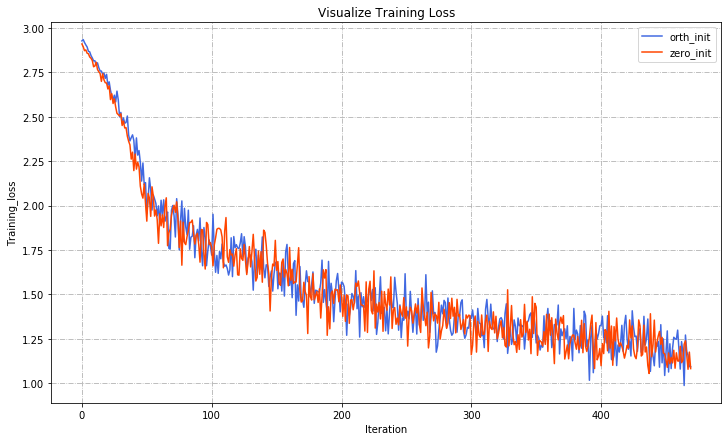

In [20]:
visualize_loss_curve2(training_loss_orth_init,training_loss_zero_init)

## 总结与分析

**总结：** 本次实验探索了循环神经网络，在验证集数据上的准确率超过了83%。个人对这个准确度结果并不满意，简单分析了一下是以下两个原因
1. 典型循环神经网络中的LSTM，GRU都擅长捕捉序列信息，当前处理的文本数据是人名,名字的长度有限, 且距离间隔比较长的字母之间无特定的关联,因此限制了循环神经网络模型捕捉语义关联的优势
2. 人名分类问题的数据集中，如Chinese和Korean在字母规律上的差异比较小，且发音规则，常见的字母组合都接近，导致模型无法正确的对二者进行划分，此外，如火星人名（我不知道这个名是怎么来的）的拼写没有任何的规律，模型自然也难以捕捉序列的信息
3. 数据的分布极其不合理，超过50%的人名都是俄国人名，造成了严重的bias

**End of Homework5**

**助教老师您幸苦了！**